## Building Deep Neural Network Model

In [59]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def sigmoid(x):
    a = 1 / (1 + np.exp(-x))
    return a

def relu(x):
    a = np.maximum(0, x)
    return a

def sigmoid_derivative(x):
    s = sigmoid(x)
    d = s * (1 - s)
    return d

def relu_derivative(x):
    c = x.copy()
    c[c<=0] = 0
    c[c>0] = 1
    return c

In [3]:
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    for i in range(1, len(layer_dims)):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(layer_dims[i-1])
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
    return parameters

In [4]:
def layer_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    
    if activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'relu':
        A = relu(Z)
    
    cache = (A_prev, W, b, Z)
    return A, cache

In [5]:
def model_forward(X, parameters):
    caches = []
    
    l = len(parameters) // 2
    A = X
    
    # 1 - (n-1) layer activation: relu
    for i in range(1, l):
        A, cache = layer_forward(A, parameters["W" + str(i)], parameters["b" + str(i)], "relu")
        caches.append(cache)
        
    # last layer activation: sigmoid
    A, cache = layer_forward(A, parameters["W" + str(l)], parameters["b" + str(l)], "sigmoid")
    caches.append(cache)
    
    return A, caches

In [6]:
def compute_cost(A, Y):
    m = Y.shape[1]
    cost = -1 / m * (np.sum(Y * np.log(A)) + np.sum((1 - Y) * np.log(1 - A)))
    cost = np.squeeze(cost)
    return cost

In [7]:
def layer_backward(dA, cache, activation):
    A_prev, W, b, Z = cache
    m = dA.shape[1]
    
    if activation == 'sigmoid':
        dZ = dA * sigmoid_derivative(Z)
    elif activation == 'relu':
        dZ = dA * relu_derivative(Z)
    
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [8]:
def model_backward(AL, Y, caches):
    grads = {}
    l = len(caches)
    m = AL.shape[1]
    
    dA = - (Y / AL - (1 - Y) / (1 - AL))
    dA, dW, db = layer_backward(dA, caches[-1], 'sigmoid')
    grads["dW" + str(l)] = dW
    grads["db" + str(l)] = db
    
    for i in reversed(range(l-1)):
        dA, dW, db = layer_backward(dA, caches[i], 'relu')
        grads["dW" + str(i + 1)] = dW
        grads["db" + str(i + 1)] = db
    
    return grads

In [9]:
def update_parameters(parameters, grads, learning_rate):
    l = len(parameters) // 2
    for i in range(l):
        parameters["W" + str(i + 1)] = parameters["W" + str(i + 1)] - learning_rate * grads["dW" + str(i + 1)]
        parameters["b" + str(i + 1)] = parameters["b" + str(i + 1)] - learning_rate * grads["db" + str(i + 1)]
        
    return parameters

## Application - Image Classification


In [10]:
# load data
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
x_train = train_dataset["train_set_x"][:]
y_train = train_dataset["train_set_y"][:].reshape((1,-1))

test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
x_test = test_dataset["test_set_x"][:]
y_test = test_dataset["test_set_y"][:].reshape((1,-1))

classes = test_dataset["list_classes"][:]

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

x_train.shape: (209, 64, 64, 3)
y_train.shape: (1, 209)
x_test.shape: (50, 64, 64, 3)
y_test.shape: (1, 50)


y = 1, This is a [b'cat'] image


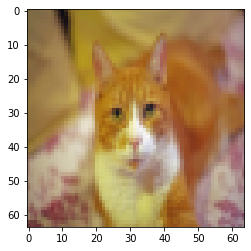

In [11]:
idx = 24
img = x_train[idx]
plt.imshow(img)
print(f"y = {y_train[:,idx][0]}, This is a {classes[y_train[:,idx]]} image")

In [12]:
# process data
x_train = x_train.reshape(x_train.shape[0], -1).T / 255.
x_test = x_test.reshape((x_test.shape[0], -1)).T / 255.
print(f"x_train.shape: {x_train.shape}")
print(f"x_test.shape: {x_test.shape}")

x_train.shape: (12288, 209)
x_test.shape: (12288, 50)


In [13]:
def model(X, Y, layer_dims, learning_rate, num_iterations, print_cost=False):
    costs = []
    
    parameters = initialize_parameters(layer_dims)
    for i in range(num_iterations):
        AL, caches = model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"{i}th iteration cost: {cost}")
    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per 100)')
    plt.title('Learning rate:' + str(learning_rate))
    plt.show()
    
    return parameters, costs    

In [14]:
def predict(X, Y, parameters):
    AL, _ = model_forward(X, parameters)
    prediction = (AL >= 0.5)
    accuracy = (np.sum(prediction * Y) + np.sum((1 - prediction) * (1 - Y))) / X.shape[1] * 100
    print(f"Accuracy: {accuracy} %")
    return prediction, accuracy

0th iteration cost: 0.6950464961800915
100th iteration cost: 0.5892596054583805
200th iteration cost: 0.5232609173622991
300th iteration cost: 0.4497686396221906
400th iteration cost: 0.42090021618838985
500th iteration cost: 0.37246403061745953
600th iteration cost: 0.347420518702019
700th iteration cost: 0.31719191987370277
800th iteration cost: 0.2664377434774658
900th iteration cost: 0.21991432807842573
1000th iteration cost: 0.14357898893623794
1100th iteration cost: 0.45309212623221073
1200th iteration cost: 0.09499357670093518
1300th iteration cost: 0.08014128076781374
1400th iteration cost: 0.06940234005536466
1500th iteration cost: 0.06021664023174592
1600th iteration cost: 0.05327415758001879
1700th iteration cost: 0.04762903262098437
1800th iteration cost: 0.04297588879436871
1900th iteration cost: 0.03903607436513821
2000th iteration cost: 0.03568313638049028
2100th iteration cost: 0.032915263730546776
2200th iteration cost: 0.03047219305912064
2300th iteration cost: 0.0283

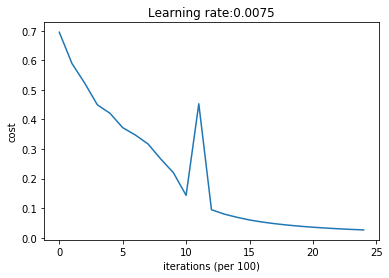

Accuracy: 100.0 %


(array([[False, False,  True, False, False, False, False,  True, False,
         False, False,  True, False,  True,  True, False, False, False,
         False,  True, False, False, False, False,  True,  True, False,
          True, False,  True, False, False, False, False, False, False,
         False, False,  True, False, False,  True,  True, False, False,
         False, False,  True, False, False,  True, False, False, False,
          True, False,  True,  True, False,  True,  True,  True, False,
         False, False, False, False, False,  True, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False,  True,  True, False, False, False,  True, False,
         False, False,  True,  True,  True, False, False,  True, False,
         False, False, False,  True, False,  True, False,  True,  True,
          True,  True,  True,  True, False, False, False, False, False,
          True, False, False, False,  True, False, False,  True,

In [15]:
two_layer = (12288, 7, 1)
two_layer_parameters, two_layer_costs = model(x_train, y_train, two_layer, 0.0075, 2500, True)
predict(x_train, y_train, two_layer_parameters)

In [16]:
test_pred_two_layer, test_acc_two_layer = predict(x_test, y_test, two_layer_parameters)

Accuracy: 74.0 %


0th iteration cost: 0.7717493284237686
100th iteration cost: 0.6720534400822914
200th iteration cost: 0.6482632048575212
300th iteration cost: 0.6115068816101356
400th iteration cost: 0.5670473268366111
500th iteration cost: 0.5401376634547799
600th iteration cost: 0.5279299569455267
700th iteration cost: 0.46547737717668514
800th iteration cost: 0.36912585249592794
900th iteration cost: 0.39174697434805356
1000th iteration cost: 0.31518698886006163
1100th iteration cost: 0.2726998441789385
1200th iteration cost: 0.23741853400268137
1300th iteration cost: 0.19960120532208644
1400th iteration cost: 0.18926300388463305
1500th iteration cost: 0.1611885466582775
1600th iteration cost: 0.14821389662363316
1700th iteration cost: 0.13777487812972944
1800th iteration cost: 0.1297401754919012
1900th iteration cost: 0.12122535068005212
2000th iteration cost: 0.11382060668633713
2100th iteration cost: 0.10783928526254132
2200th iteration cost: 0.10285466069352679
2300th iteration cost: 0.10089745

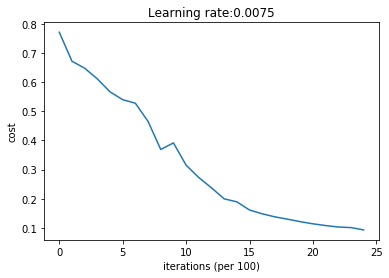

Accuracy: 98.56459330143541 %


(array([[False, False,  True, False, False, False, False,  True, False,
         False, False,  True, False,  True,  True, False, False, False,
         False,  True, False, False, False, False,  True,  True, False,
          True, False,  True, False, False, False, False, False, False,
         False, False,  True, False, False,  True,  True, False, False,
         False, False,  True, False, False,  True, False, False, False,
          True, False,  True,  True, False,  True,  True,  True, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False,  True,  True, False, False, False,  True, False,
         False, False, False,  True,  True, False, False,  True, False,
         False, False, False,  True, False,  True, False,  True,  True,
          True,  True,  True,  True, False, False, False, False, False,
          True, False, False, False,  True, False, False, False,

In [17]:
four_layer = [12288, 20, 7, 5, 1]
four_layer_parameters, four_layer_costs = model(x_train, y_train, four_layer, 0.0075, 2500, True)
predict(x_train, y_train, four_layer_parameters)

In [18]:
test_pred_four_layer, test_acc_four_layer = predict(x_test, y_test, four_layer_parameters)

Accuracy: 80.0 %


In [19]:
def print_mislabeled_images(x, y, prediction):
    a = y + prediction
    mislabeled_indices = np.where(a == 1)
    
    plt.rcParams['figure.figsize'] = (40.0, 40.0)
    num_images = len(mislabeled_indices[0])
    classes = ['Cat', 'Non-cat']
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title(f"Prediction: {classes[1 - prediction[0,index]]} , Class: {classes[1 - y[0,index]]}")

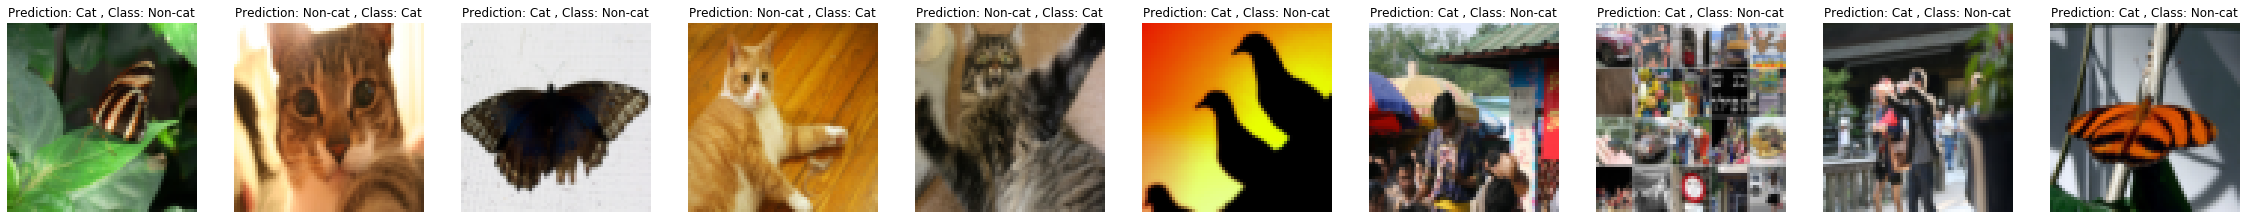

In [20]:
print_mislabeled_images(x_test, y_test, test_pred_four_layer)

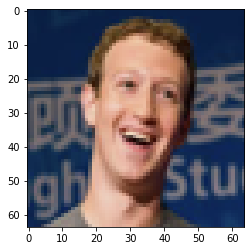

In [60]:
image = Image.open('mz_non_cat.png')
image = image.resize((64, 64))
image = np.asarray(image)[:,:,:3]
plt.imshow(image)

In [56]:
image_flatten = image.reshape(1, -1).T
image_flatten.shape

(12288, 1)

In [57]:
pred, acc = test_pred_four_layer, test_acc_four_layer = predict(image_flatten, np.array([1]), four_layer_parameters)

Accuracy: 100.0 %


In [58]:
print(f"This image is {('Cat', 'Non-cat')[1 * pred.squeeze()]} image!")

This image is Non-cat image!
